Anchors for MNIST

In [ ]:
!pip install alibi

In [ ]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from alibi.explainers import AnchorImage

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print('x_train shape:', x_train.shape, 'y_train shape:', y_train.shape)

x_train shape: (60000, 28, 28) y_train shape: (60000,)


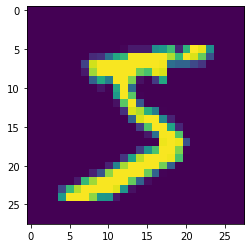

In [ ]:
idx = 0
plt.imshow(x_train[idx]);

In [ ]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = np.reshape(x_train, x_train.shape + (1,))
x_test = np.reshape(x_test, x_test.shape + (1,))
print('x_train shape:', x_train.shape, 'x_test shape:', x_test.shape)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print('y_train shape:', y_train.shape, 'y_test shape:', y_test.shape)

x_train shape: (60000, 28, 28, 1) x_test shape: (10000, 28, 28, 1)
y_train shape: (60000, 10) y_test shape: (10000, 10)


In [ ]:
def model():
    x_in = Input(shape=(28, 28, 1))
    x = Conv2D(filters=64, kernel_size=2, padding='same', activation='relu')(x_in)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(filters=32, kernel_size=2, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x_out = Dense(10, activation='softmax')(x)

    cnn = Model(inputs=x_in, outputs=x_out)
    cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return cnn

In [ ]:
cnn = model()
cnn.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 32)        8224      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 7, 32)         

In [ ]:
cnn.fit(x_train, y_train, batch_size=64, epochs=3)

Epoch 1/3
938/938 [==============================] - 71s 76ms/step - loss: 0.3295 - accuracy: 0.8959
Epoch 2/3
938/938 [==============================] - 70s 75ms/step - loss: 0.1239 - accuracy: 0.9618
Epoch 3/3
938/938 [==============================] - 76s 81ms/step - loss: 0.0933 - accuracy: 0.9707


In [ ]:
# Evaluate the model on test set
score = cnn.evaluate(x_test, y_test, verbose=0)
print('Test accuracy: ', score[1])

Test accuracy:  0.9866999983787537


In [ ]:
def superpixel(image, size=(4, 7)):
    segments = np.zeros([image.shape[0], image.shape[1]])
    row_idx, col_idx = np.where(segments == 0)
    for i, j in zip(row_idx, col_idx):
        segments[i, j] = int((image.shape[1]/size[1]) * (i//size[0]) + j//size[1])
    return segments

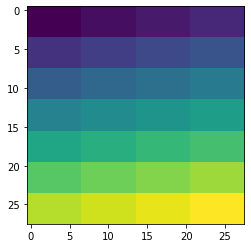

In [ ]:
segments = superpixel(x_train[idx])
plt.imshow(segments);

In [ ]:
predict_fn = lambda x: cnn.predict(x)

In [ ]:
image_shape = x_train[idx].shape
explainer = AnchorImage(predict_fn, image_shape, segmentation_fn=superpixel)

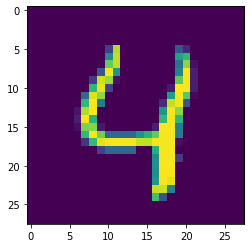

In [ ]:
i = 4
image = x_test[i]
plt.imshow(image[:,:,0]);

In [ ]:
cnn.predict(image.reshape(1, 28, 28, 1)).argmax()

4

In [ ]:
explanation = explainer.explain(image, threshold=.95, p_sample=.8, seed=0)

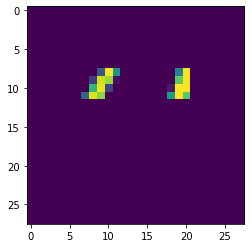

In [ ]:
plt.imshow(explanation.anchor[:,:,0]);

Explanation: 

The anchor explanations have been done on the image of a handwritten number '4' from the MNIST Image Dataset, which is shown in terms of the superpixels up above. 

Upon generating the anchor explanation for that image, we get the image shown below, which shows us all the pixels of the original image that were sufficient for the model to make the prediction that the digit in the image was '4'. We get two dense pixel areas that are unique. Upon closer inspection, we realise that, generally speaking, no other digit has pixels on both of the areas shown in the Anchors explanation. There might have been some overlap with other digits if only one area was shown in the Anchors explanation. 

Therefore, we can say that, if only the pixels shown in the Anchors explanation were present in the original image, the model would still make the same prediction that the digit was '4' as these pixels are sufficient for the model to make that prediction. 

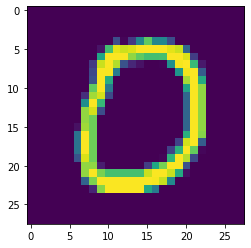

In [ ]:
i = 10
image = x_test[i]
plt.imshow(image[:,:,0]);

In [ ]:
cnn.predict(image.reshape(1, 28, 28, 1)).argmax()

0

In [ ]:
explanation = explainer.explain(image, threshold=.95, p_sample=.8, seed=0)

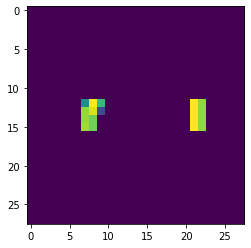

In [ ]:
plt.imshow(explanation.anchor[:,:,0]);

Explanation:

Similarly to the first example, the anchor explanations have been done on the image of a handwritten number '0' from the MNIST Image Dataset, which is shown in terms of the superpixels up above. 

Upon generating the anchor explanation for that image, we get the image shown below, which shows us all the pixels of the original image that were sufficient for the model to make the prediction that the digit in the image was '0'. We get two dense pixel areas that are unique on the left and right side. No other digit has curved lines on the central left and central right side. Therefore, we can conclude that the digit is '0'.

Therefore, we can say that, if only the pixels shown in the Anchors explanation were present in the original image, the model would still make the same prediction that the digit was '0' as these pixels are sufficient for the model to make that prediction. 